In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#For scilencing the Warnings:
import warnings

warnings.filterwarnings('ignore')

In [50]:
Car_data = pd.read_csv("used_cars.csv")
Car_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


In [51]:
print(Car_data.info(), '\n\n', 'Null values in each column:')
Car_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB
None 

 Null values in each column:


brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [52]:
col_with_null_values= Car_data.columns[Car_data.isnull().any().tolist()]
col_with_null_values

Index(['fuel_type', 'accident', 'clean_title'], dtype='object')

In [53]:
Car_data['clean_title']=Car_data['clean_title'].fillna('No')
for column in col_with_null_values:
    Car_data[column]=Car_data[column].fillna(Car_data[column].mode()[0])

Car_data.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [54]:
#For Car milage:
Car_data['milage']= Car_data['milage'].replace([',', ' mi.'], ['',''], regex=True).astype(int)

#For price:
Car_data['price']= Car_data['price'].replace(r'[$,]','', regex=True).astype(int)

Car_data[['milage', 'price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   milage  4009 non-null   int64
 1   price   4009 non-null   int64
dtypes: int64(2)
memory usage: 62.8 KB


In [55]:
def remove_outliers(column, df):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR= Q3-Q1
    lower_whisker= Q1- 1.5*IQR
    upper_whisker= Q3+ 1.5*IQR
    df= df[(df[column]>=lower_whisker) & (df[column]<=upper_whisker)]
    return df

numeric_columns= ['milage', 'price']
for col in numeric_columns:
    Car_data=remove_outliers(col, Car_data)

Car_data.reset_index(inplace=True, drop=True)
Car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3689 entries, 0 to 3688
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         3689 non-null   object
 1   model         3689 non-null   object
 2   model_year    3689 non-null   int64 
 3   milage        3689 non-null   int64 
 4   fuel_type     3689 non-null   object
 5   engine        3689 non-null   object
 6   transmission  3689 non-null   object
 7   ext_col       3689 non-null   object
 8   int_col       3689 non-null   object
 9   accident      3689 non-null   object
 10  clean_title   3689 non-null   object
 11  price         3689 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 346.0+ KB


In [56]:
Car_data.drop_duplicates()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,No,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,No,34999
...,...,...,...,...,...,...,...,...,...,...,...,...
3684,Mercedes-Benz,E-Class E 300 4MATIC,2018,53705,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Black,Black,At least 1 accident or damage reported,Yes,25900
3685,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
3686,Porsche,Taycan,2022,2116,Gasoline,Electric,Automatic,Black,Black,None reported,No,90998
3687,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


In [57]:
Car_data= Car_data[~Car_data.apply(lambda row: row.astype(str).str.contains('–').any(), axis=1)]
Car_data.shape

(3534, 12)

In [58]:
print('Total Gorups Beofre:\n', len(Car_data['transmission'].unique()))
Car_data['transmission']=Car_data['transmission'].str.replace('Automatic', 'A/T')
Car_data['transmission']=Car_data['transmission'].str.replace('-Spd', '-Speed')
Car_data['transmission']=Car_data['transmission'].str.replace('Manual', 'M/T')
Car_data['transmission']=Car_data['transmission'].str.replace('6 Speed Mt', '6-Speed M/T')
print('Total Groups After:\n', len(Car_data['transmission'].unique()))

Total Gorups Beofre:
 48
Total Groups After:
 36


In [59]:
Car_data.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed A/T,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,A/T,Blue,Black,None reported,No,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed A/T,Glacier White Metallic,Black,None reported,No,34999
5,Acura,ILX 2.4L,2016,136397,Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,No,14798
6,Audi,S3 2.0T Premium Plus,2017,84000,Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,31000
7,Lexus,RC 350 F Sport,2021,23436,Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,41927
8,Tesla,Model X Long Range Plus,2020,34000,Gasoline,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,69950
9,Land,Rover Range Rover Sport 3.0 Supercharged HST,2021,27608,Gasoline,V6,A/T,Fuji White,Pimento / Ebony,None reported,No,73897


In [60]:
Car_data.select_dtypes(include=int).describe()

,model_year,milage,price
count,3534.000000,3534.000000,3534.000000
mean,2015.585173,64593.961800,33993.360498
std,5.726769,46546.329271,21115.007776
min,1996.000000,100.000000,2000.000000
25%,2012.000000,26000.000000,17000.000000
50%,2017.000000,55075.000000,29999.000000
75%,2020.000000,94075.000000,45999.000000
max,2024.000000,200000.000000,98000.000000


In [61]:
Car_data.select_dtypes(include=object).describe()

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,3534,3534,3534,3534,3534,3534,3534,3534,3534
unique,52,1700,6,1015,36,271,131,2,2
top,BMW,M3 Base,Gasoline,2.0L I4 16V GDI DOHC Turbo,A/T,Black,Black,None reported,Yes
freq,352,29,3098,48,1109,807,1870,2633,3042


In [62]:
Car_data[numeric_columns].corr()

,milage,price
milage,1.000000,-0.650475
price,-0.650475,1.000000


[]

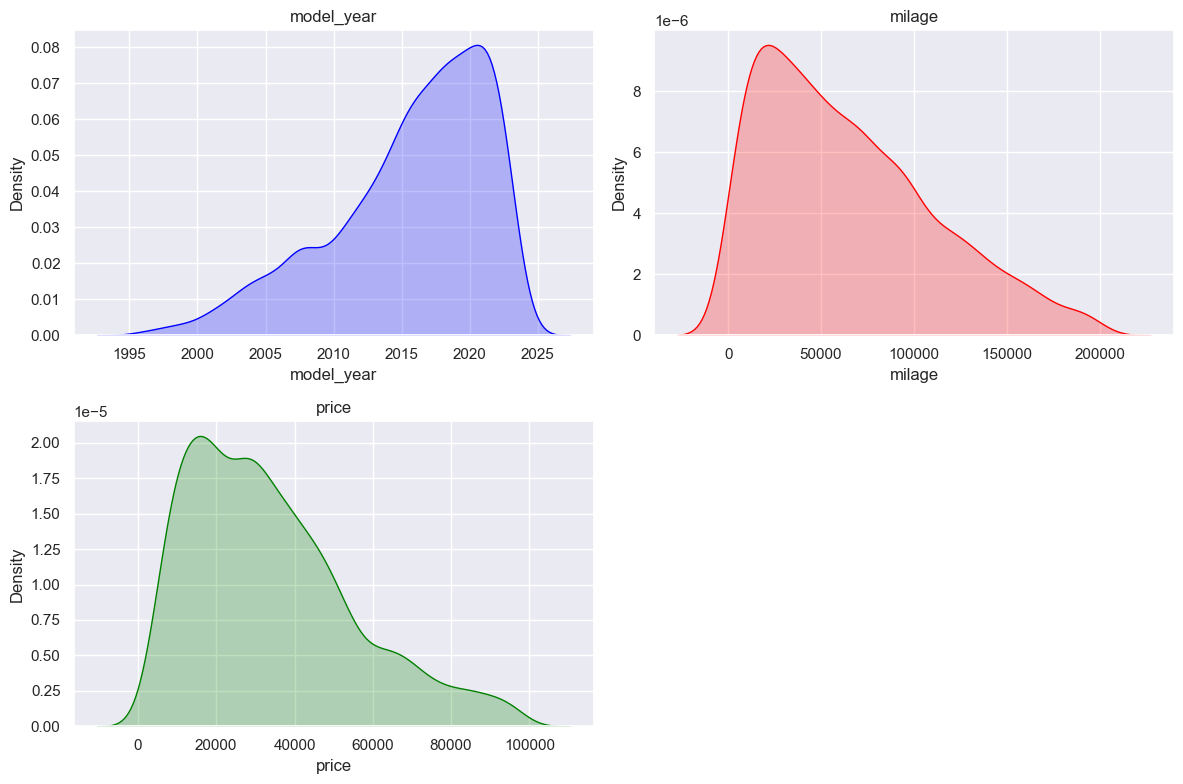

In [63]:
n_rows=2
numeric_column_name=Car_data.select_dtypes(include=int).columns
n_cols= int(np.ceil(len(numeric_column_name)/n_rows))
color=['blue', 'red', 'green']

plt.figure(figsize=(6*n_rows, 4*n_cols))
for idx, column in enumerate(Car_data[numeric_column_name],1):
    plt.subplot(n_rows, n_cols, idx)
    #sns.histplot(data=Car_data, x=column, bins=50, kde=True)
    sns.kdeplot(data=Car_data, x= column, fill=color[idx-1], color=color[idx-1])
    plt.title(column)
plt.tight_layout()
plt.plot()

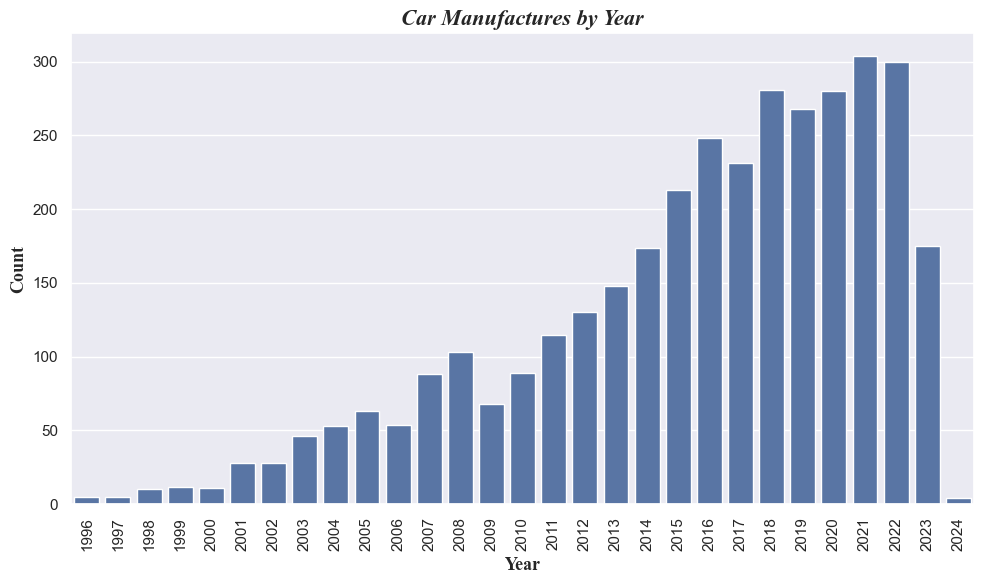

In [64]:
plt.figure(figsize=(10,6))
sns.countplot(data=Car_data, x='model_year', width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Year', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.ylabel('Count', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.title('Car Manufactures by Year', fontdict={'family': 'Times New Roman', 'style': 'oblique', 'size':16, 'weight': 'bold'})
sns.set_style('darkgrid')
sns.set_theme('notebook')
plt.tight_layout()
plt.show()

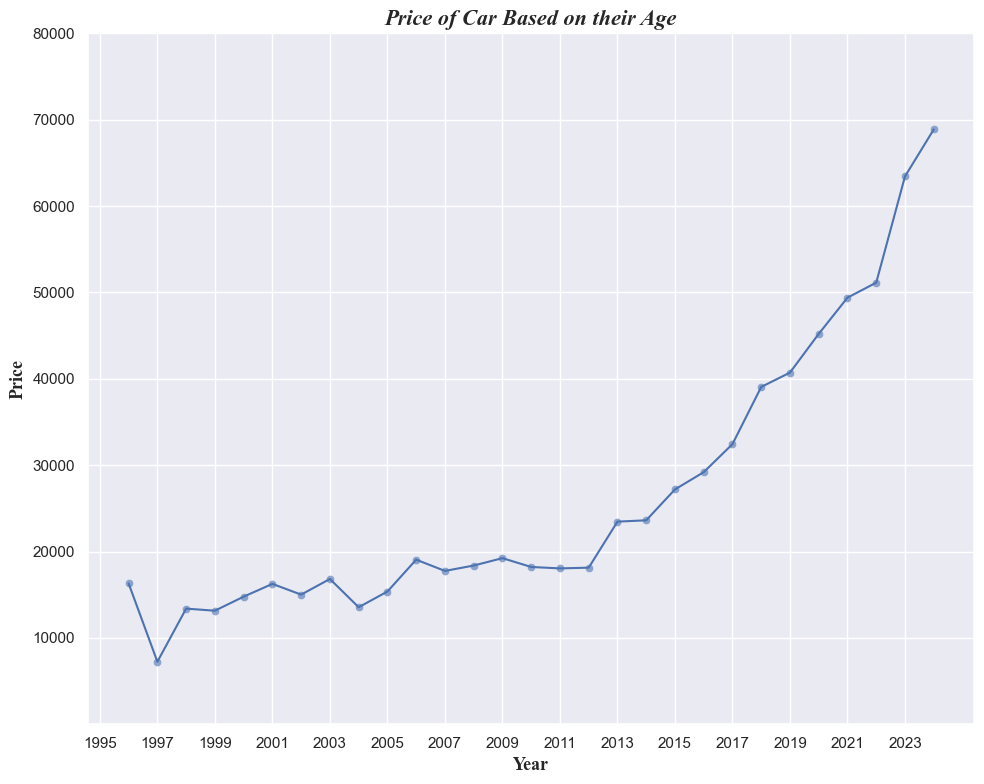

In [65]:
year_price= pd.DataFrame(Car_data.groupby(by='model_year')['price'].mean()).reset_index()
plt.figure(figsize=(10,8))
sns.lineplot(data=year_price, x= 'model_year', y='price')
sns.scatterplot(data=year_price, x= 'model_year', y='price', alpha=0.6)
plt.xticks(range(1995, 2025,2))
plt.yticks(range(10000,120000, 10000))
plt.ylim(0,80000)
plt.xlabel('Year', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.ylabel('Price', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.title('Price of Car Based on their Age', fontdict={'family': 'Times New Roman', 'size':16, 'weight': 'bold', 'style': 'oblique'})
sns.set_theme('notebook')
sns.set_style('whitegrid')
plt.tight_layout()
plt.show()

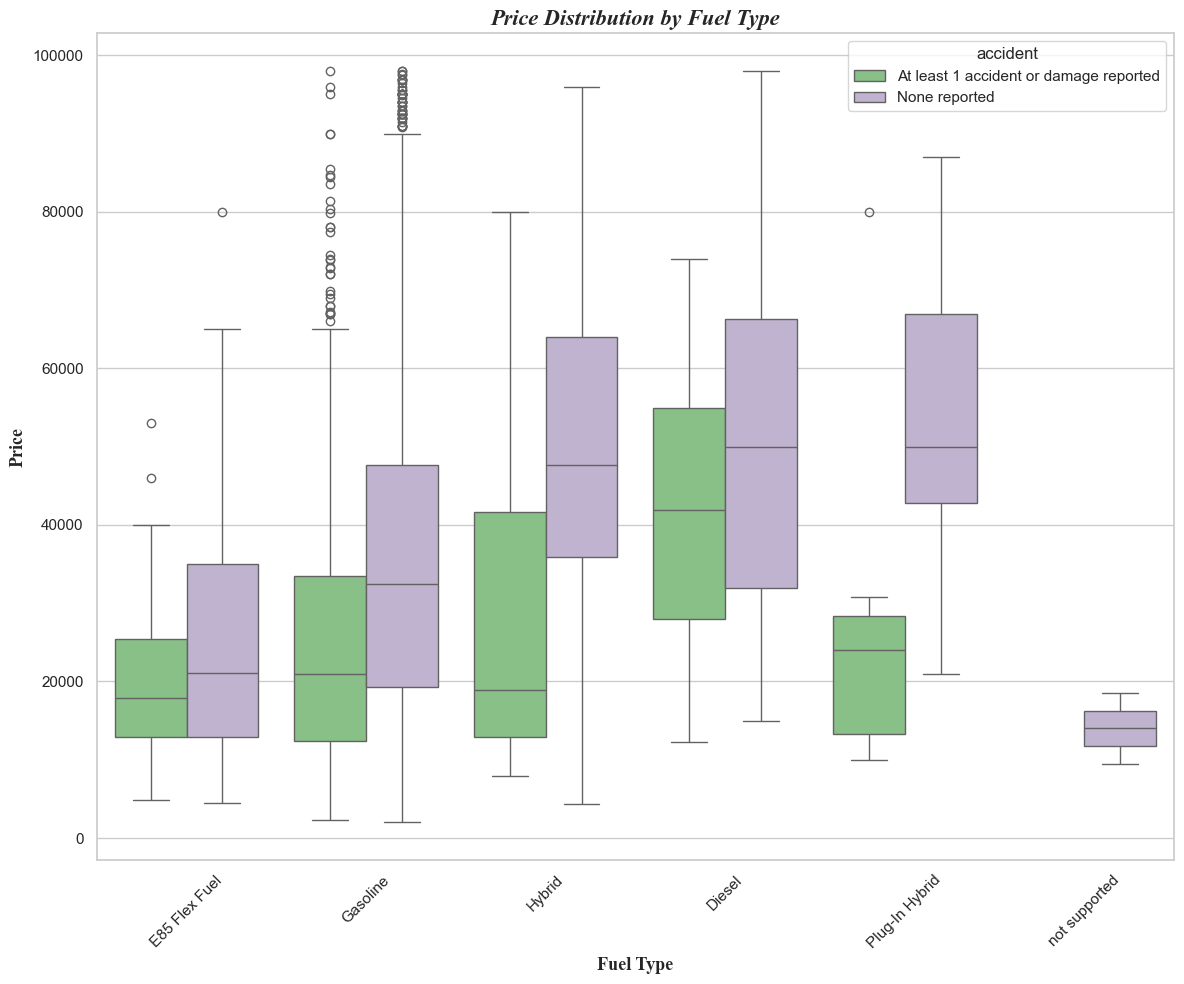

In [66]:
plt.figure(figsize=(12,10))
sns.boxplot(data=Car_data, x='fuel_type', y='price', hue='accident', palette='Accent')
plt.xticks(rotation=45)
plt.xlabel('Fuel Type', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.ylabel('Price', fontdict={'family': 'Times New Roman', 'size':13, 'weight': 'bold'})
plt.title('Price Distribution by Fuel Type', fontdict={'family': 'Times New Roman', 'size':16, 'style': 'oblique', 'weight': 'bold'})
plt.tight_layout()
sns.set_theme('notebook')
plt.show()

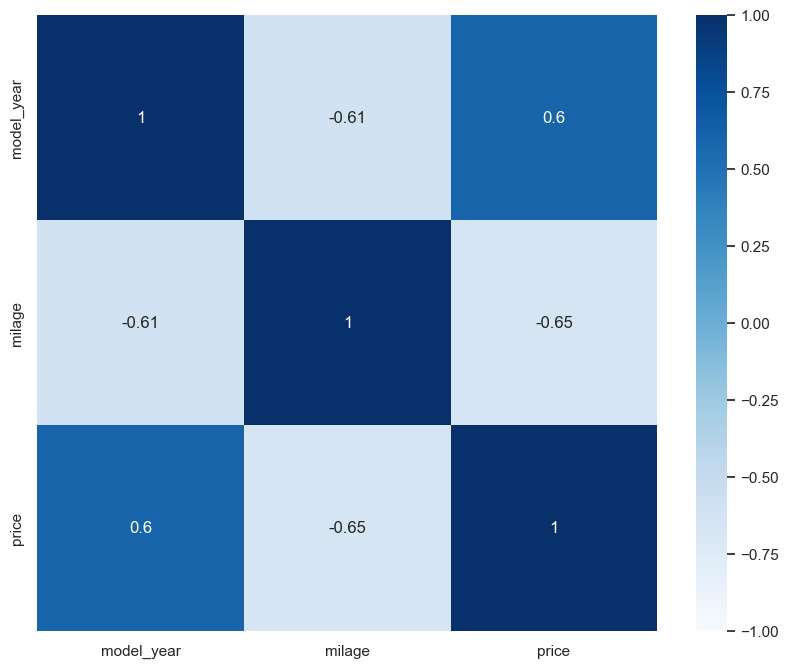

In [67]:
correlation_matrix = Car_data.select_dtypes(exclude='object').corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=-1)
plt.show()

In [68]:
Car_data['horse_power']= Car_data['engine'].str.extract(r'(\d+(?:\.\d+)?)\s*HP').astype(float)
Car_data['liter_capacity']= Car_data['engine'].str.extract(r'(\d+(?:\.\d+)?)\s*L').astype(float)



#Seperating fratures and labels:
X= Car_data.drop(columns=['price', 'model_year', 'engine'])
y= Car_data['price']

In [69]:
#For cylinders:
def extract_cylinders(text):
    # First try to find pattern like "V6", "V8", "H4", etc.
    match = re.search(r'\b[HVILR]?(\d)[\s-]?Cylinder\b|\b([VHI])(\d)\b', text, re.IGNORECASE)
    if match:
        if match.group(1):
            return int(match.group(1))  # From "X Cylinder"
        elif match.group(3):
            return int(match.group(3))  # From "V6", "H4", etc.
    else:
        # Try to find a standalone number followed by "Cylinder"
        match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
        if match:
            return int(match.group(1))
    return None

Car_data['cylinders'] = Car_data['engine'].apply(extract_cylinders)

In [70]:
#For Transmission:
Car_data['gear']= Car_data['transmission'].str.extract(r'(\d+(?:\.\d+)?)\s*-Speed').astype(float)

def extract_transmission(transmission_str):
    if 'A/T' in transmission_str:
        return 'A/T'
    elif 'M/T' in transmission_str:
        return 'M/T'
    elif 'Dual' in transmission_str:
        return 'Dual'
    else:
        return 'Unknown'  # In case there's something unexpected

Car_data['transmission']= Car_data['transmission'].apply(extract_transmission)
Car_data['transmission']= Car_data['transmission'].replace('Unknown', Car_data['transmission'].mode()[0])

In [71]:
#Age of Cars:
Car_data['age']=2025- Car_data['model_year']

In [72]:
for idx in Car_data.index:
    if 'electric' in Car_data.loc[idx, 'engine'].lower():
        Car_data.loc[idx, 'electric']= True
    else:
        Car_data.loc[idx, 'electric']= False

In [73]:
#Cleaning the Null values for these new features:
for column in ['horse_power', 'liter_capacity']:
    Car_data[column]= Car_data[column].fillna(Car_data[column].median())
for column in ['cylinders', 'gear']:
    Car_data[column]= Car_data[column].fillna(Car_data[column].mode()[0])

In [74]:
Car_data['clean_title']=Car_data['clean_title'].replace({'Yes': True, 'No': False})

In [75]:
X= Car_data.drop(columns=['price', 'model_year', 'engine'])
y= Car_data['price']

In [76]:
categorical_features= ['brand', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'cylinders', 'model']

#Initializing the encoder:
encoder= OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#Fitting and transforming the categorical data:
encoded_features= encoder.fit_transform(X[categorical_features])

#Generating correct column names for encoded features:
encoded_car_data= pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=X.index)

#Concatinating the original dataframe with the encoded columns
X= pd.concat([X, encoded_car_data], axis=1)

#Dropping the original categorical columns from the datatframe:
X.drop(columns=categorical_features, inplace=True)
X

,milage,accident,clean_title,horse_power,liter_capacity,gear,age,electric,brand_Acura,brand_Alfa,...,model_e-tron Premium,model_e-tron Prestige,model_i3 120Ah w/Range Extender,model_i3 Base,model_i3 Base w/Range Extender,model_i8 Base,model_tC Anniversary Edition,model_tC Base,model_tC Release Series 6.0,model_xB Base
0,51000,At least 1 accident or damage reported,True,300.0,3.7,6.0,12,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34742,At least 1 accident or damage reported,True,310.0,3.8,8.0,4,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22372,None reported,False,310.0,3.5,6.0,3,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88900,None reported,True,354.0,3.5,7.0,10,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9835,None reported,False,310.0,2.0,8.0,4,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,53705,At least 1 accident or damage reported,True,241.0,2.0,6.0,7,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3685,10900,None reported,True,349.0,3.0,6.0,3,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3686,2116,None reported,False,310.0,3.5,6.0,3,True,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3687,33000,None reported,True,450.0,3.5,6.0,5,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
custom_map = {
    'None reported': 1,  # Better condition
    'At least 1 accident or damage reported': 0  # Worse condition
}
X['accident']=X['accident'].map(custom_map)

In [78]:
continious_feature=['milage', 'age', 'horse_power', 'liter_capacity', 'gear']
scaler= StandardScaler()
scaled_feature= scaler.fit_transform(X[continious_feature])
scaled_car_data= pd.DataFrame(scaled_feature, 
                              columns=scaler.get_feature_names_out(continious_feature), 
                              index=X.index)

X.drop(columns=continious_feature, inplace=True)
X= pd.concat([X, scaled_car_data], axis=1)


In [79]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
rf_model= RandomForestRegressor(random_state=42)

#Training
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [81]:
y_pred= rf_model.predict(X_test)

#Evaluating the error (MSE & RMSE)
mae= mean_absolute_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
R2= r2_score(y_test, y_pred)
print(f'Mean Absolute Error(MAE): {mae:.4f}\nRoot Mean Squared Error(RMSE): {rmse:.4f}\nR² Score: {R2:.4f}')

Mean Absolute Error(MAE): 5757.0474
Root Mean Squared Error(RMSE): 8676.3654
R² Score: 0.8406


In [82]:
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_dist,
    n_iter=15,  # Try only 20 random combinations
    cv=4,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 69}


,n_estimators,69
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [83]:
y_pred_final = best_rf_model.predict(X_test)

# Final Evaluation Metrics
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print(f"Final MAE: {mae_final:.4f}")
print(f"Final MSE: {rmse_final:.4f}")
print(f"Final R²: {r2_final:.4f}")

Final MAE: 5795.2394
Final MSE: 8705.9198
Final R²: 0.8395


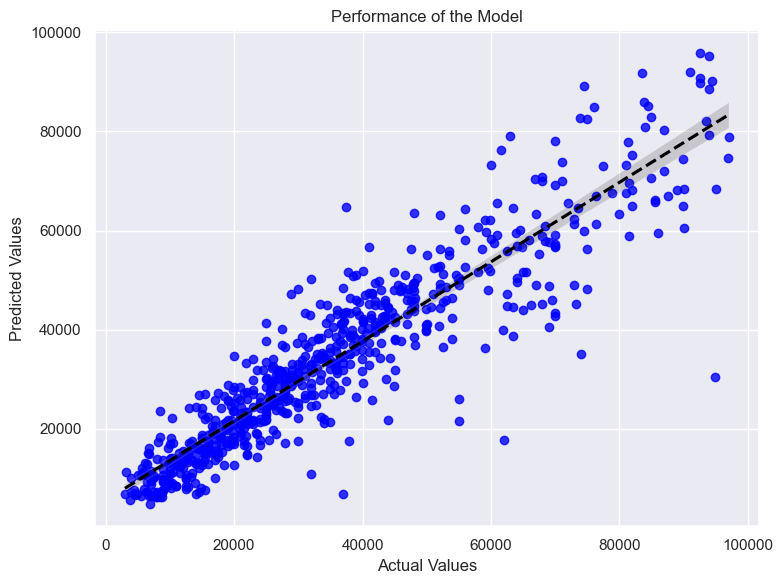

In [84]:
plt.figure(figsize=(8,6))
sns.regplot(x=y_test, y=y_pred, color='blue', line_kws={'color':'black', 'linestyle':'--'})
sns.set_style('whitegrid')
sns.set_theme('notebook')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Performance of the Model')
plt.tight_layout()
plt.show()

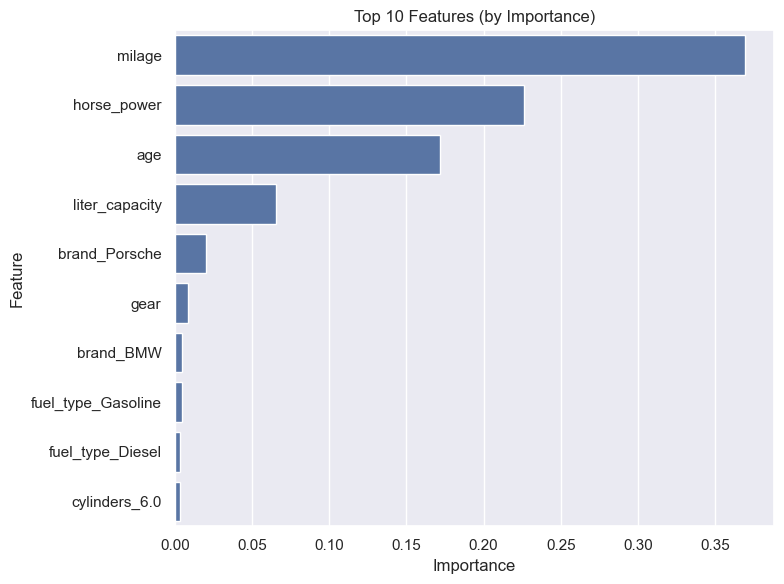

In [85]:
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for easy sorting
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
plt.title('Top 10 Features (by Importance)')
sns.barplot(data=feature_df, x='Importance', y= 'Feature')
plt.tight_layout()
sns.set_style('white')
sns.set_theme('notebook')
plt.show()